## Classification Model for identifying Maternal Health Risk

Shannon Pflueger, Nelli Hovhannisyan, Joseph Lim

# Introduction

Maternal health remains a critical issue worldwide, especially in rural regions and among lower-middle-class families in emerging countries. The lack of access to proper healthcare, inadequate information about maternal care, and insufficient monitoring during pregnancy contribute to high maternal mortality rates. The significance of timely interventions and constant monitoring during pregnancy cannot be overstated, as each moment is crucial to ensuring the health and safety of both the mother and the baby.
This report investigates maternal health risks using exploratory data analysis and classification techniques such as Logistic regression, SVC and Naive Bayes to identify key factors that contribute to complications during pregnancy. 

The primary question addressed in this project is: What are the key indicators that predict maternal health risks during pregnancy?

To answer this question, a dataset containing information on various maternal health factors was used. Leading to the goal of the project which is to create a predictive model that can evaluate the risk factors associated with pregnancy.

In [1]:
import pandas as pd
import numpy as np
import pandera as paimport os

## About Data 

Data was taken from the UC Irvine Machine Learning Repository \
Dataset link - https://archive.ics.uci.edu/dataset/863/maternal+health+risk \
Column descriptions: 

- Age: Age in years when a woman is pregnant.
- SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
- HeartRate: A normal resting heart rate in beats per minute.
- Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

In [2]:
import os

def validate_csv(file_path):
    """
    Validates if the input file is a valid CSV file.
    
    Args:
        file_path (str): Path to the file.
    
    Returns:
        pd.DataFrame: Loaded DataFrame if the file is valid.
        None: If the file is not valid.
    """
    # Check if the file extension is .csv
    if not file_path.endswith(".csv"):
        print(f"Error: The file '{file_path}' is not a CSV file.")
        return None

    try:
        # Attempt to read the file with Pandas
        data = pd.read_csv(file_path)
        print(f"'{file_path}' is a valid CSV file.")
        return data
    except pd.errors.ParserError:
        print(f"Error: The file '{file_path}' is not a valid CSV file.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None

file_path = "../data/Maternal Health Risk Data Set.csv"
df = validate_csv(file_path)

if df is not None:
    print("Data loaded successfully.")
    print(df.head())
else:
    print("Failed to load data.")

'../data/Maternal Health Risk Data Set.csv' is a valid CSV file.
Data loaded successfully.
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


# Data Validation

We are going to drop two rows which contain data that is out of normal range. These two rows both include a heart rate of 7 (beats per minute). This is clearly an error since humans on average have a heart rate between 60-100 bpm. Moreover, heart rate during pregnancy typically increases on average, for various reason, though there is no clear upper limit defined to be normal.

In [7]:
df = df[df['HeartRate'] != 7]

In [8]:
# validate data
schema = pa.DataFrameSchema(
    {
        "RiskLevel": pa.Column(str, pa.Check.isin(["high risk", "mid risk", "low risk"])),
        "Age": pa.Column(int, pa.Check.between(10, 70)),
        "SystolicBP": pa.Column(int, pa.Check.between(65, 185)),
        "DiastolicBP": pa.Column(int, pa.Check.between(40, 125)),
        "BS": pa.Column(float, pa.Check.between(3, 20)),
        "BodyTemp": pa.Column(float, pa.Check.between(94, 105)),
        "HeartRate": pa.Column(int, pa.Check.between(50, 110))
    },
    checks=[
        #pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows present."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows present.")
    ]
)

In [9]:
# Run validation tests on our dataframe
schema.validate(df, lazy=True)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [10]:
# Check how many duplicated rows we have
print(f"There are {df.duplicated().sum()} duplicated rows")

There are 561 duplicated rows


In [ ]:
df.info()
df.describe()

Let's make our target variable RiskLevel numeric by assigning 0 to low risk, 1 to mid risk and 2 to high risk later for the EDA. 

In [5]:
df_eda = df.copy()
df_eda['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [6]:
RiskLevel = {'low risk':0, 
        'mid risk':1, 
        'high risk':2}

df_eda['RiskLevel'] = df_eda['RiskLevel'].map(RiskLevel).astype(float)
df_eda

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2.0
1,35,140,90,13.0,98.0,70,2.0
2,29,90,70,8.0,100.0,80,2.0
3,30,140,85,7.0,98.0,70,2.0
4,35,120,60,6.1,98.0,76,0.0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2.0
1010,55,120,90,18.0,98.0,60,2.0
1011,35,85,60,19.0,98.0,86,2.0
1012,43,120,90,18.0,98.0,70,2.0


## EDA

We can see that we don't have any missing values and also all features beside the target variable are numeric. 

In [7]:
import altair as alt

In [8]:
df_eda.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

We don't have too many observations (1014), but can still be enough for initial modeling

In [9]:
df_eda.shape

(1014, 7)

We have somewhat balanced data, with high risk having the fewest observations and low risk having the most.

In [10]:
chart = alt.Chart(df).mark_bar(color = 'steelblue').encode(
    x = alt.X('RiskLevel', title = 'Risk Level', axis = alt.Axis(labelAngle = 0)),
    y = alt.Y('count()', title = 'Count'),
    color = alt.Color('RiskLevel:N', title = 'Risk Level')
).properties(
    title = "Countplot of Risk Level",
    width = 300,
    height = 300
)

chart

alt.Chart(...)

Let's discuss some of the relations from the heatmap of the dataset:

- The "Risk Level" our target variable exhibits a noticeable correlation with "Blood Pressure" This suggests that individuals with higher or lower blood pressure levels may tend to fall into distinct risk categories. As a result, "Blood Pressure" could serve as an essential predictor in later stages of analysis.
- The upper (systolic) and lower (diastolic) blood pressure values show a strong correlation. This is expected because both measurements are closely related physiological metrics. While we might have considered dropping one of them, the correlation is not higher than 0.8, so we will retain both, as they may still provide valuable information when combined with other features.

In [11]:
correlation_matrix = df_eda.corr().abs().round(2).reset_index().melt(
    id_vars = 'index', 
    var_name = 'Variable', 
    value_name = 'Correlation'
)

heatmap = alt.Chart(correlation_matrix).mark_rect().encode(
    x = alt.X('Variable:N', title = '', sort = None),
    y = alt.Y('index:N', title = '', sort = None),
    color = alt.Color('Correlation:Q', scale = alt.Scale(scheme = 'viridis'), title = 'Correlation')
).properties(
    width = 600,
    height = 400
)

text = alt.Chart(correlation_matrix).mark_text(baseline = 'middle').encode(
    x = alt.X('Variable:N', sort = None, axis = alt.Axis(labelAngle = -45)),
    y = alt.Y('index:N', sort = None),
    text = alt.Text('Correlation:Q', format = '.2f'),
    color = alt.condition(
        'datum.Correlation > 0.5', 
        alt.value('white'), 
        alt.value('black')
    )
).properties(
    title = "Heatmap of the Maternal Health"
)

final_chart = heatmap + text

final_chart

alt.LayerChart(...)

In [12]:
columns = [col for col in df.columns.tolist() if col != 'RiskLevel']

boxplots = [
    alt.Chart(df).mark_boxplot(extent = 'min-max').encode(
        x = alt.X('RiskLevel:N', title = 'Risk Level', axis = alt.Axis(labelAngle = 0)),
        y = alt.Y(f'{col}:Q', title = col),
        color = 'RiskLevel:N'
    ).properties(
        title = f'Boxplot of {col} by RiskLevel',
        width = 300,
        height = 200
    )
    for col in columns
]

final_chart = alt.vconcat(*boxplots).resolve_scale(
    color = 'independent',
    y = 'independent'
)

final_chart

alt.VConcatChart(...)

We can see from the boxplots that women in the high-risk group generally have higher values across all our features. For example, older women are more likely to be classified as high risk. Additionally, the high-risk group shows a wider range for upper blood pressure and blood glucose levels, with the median value being slightly higher than that of the other groups.
Another observation here is that there are quite a lot of outliers for the low risk category.

# Data Modeling

In [13]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform, uniform, randint

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [14]:
train_df, test_df =train_test_split(df, test_size=0.2, random_state=123)
X_train = train_df.drop(columns=["RiskLevel"])
X_test = test_df.drop(columns=["RiskLevel"])
y_train = train_df["RiskLevel"]
y_test = test_df["RiskLevel"]

In [14]:
# Data Validation for Checking Correlation
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks.data_integrity import FeatureFeatureCorrelation

maternal_train_ds = Dataset(train_df, label="RiskLevel", cat_features=[])

check_feat_corr = FeatureFeatureCorrelation()
check_feat_corr_result = check_feat_corr.run(maternal_train_ds)
check_feat_corr_result


## The Baseline Model: Dummy Classifier

In [15]:
dummy_clf = DummyClassifier()
scores = cross_validate(dummy_clf, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)['test_score'].mean()

0.4007377295995182

The cross validation score of a baseline dummy classifier is 0.4.

## Gaussian Bayes Modeling

Let's first train Gaussian Naive Bayes model and evaluate its performance to the baseline model.

In [16]:
gaus_nb_pipe = make_pipeline(StandardScaler(), GaussianNB())
gaus_nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [17]:
cv_results = cross_validate(gaus_nb_pipe, X_train, y_train, return_train_score=True)
results_df = pd.DataFrame(cv_results)
results_df

,fit_time,score_time,test_score,train_score
0,0.003668,0.001863,0.582822,0.604938
1,0.002694,0.001323,0.617284,0.611710
2,0.003121,0.001312,0.604938,0.602465
3,0.003522,0.001161,0.629630,0.596302
4,0.002791,0.001097,0.567901,0.604006


The results of the Gaussian Naive Bayes model are better than the dummy model but not by a lot. Based on this we're going to focus on other models and choose one that performs better.

## Model Comparison between Decision Tree, Logistic Regression and SVC
Since Gaussian Naive Bayes model is slightly better than the baseline model, we are interested if there are other models that can perform better. The objective here is to compare the cross-valdation scores of Decision Tree, Logistic Regression and SVC. Before passing the data to a machine learning model, we will apply some `StandardScaler()` transformations on the numeric features.

In [18]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "RBF SVM": SVC(random_state=123),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=123),
}

In [19]:
# The function below is adopted from DSCI571 Supervides Learning I Lecture 4 notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [20]:
results_df = None
results_dict = {}

for model_name, model in models.items():
    clf_pipe = make_pipeline(StandardScaler(), model)
    results_dict[model_name] = mean_std_cross_val_scores(
        clf_pipe, X_train, y_train, cv=10, return_train_score=True, error_score='raise'
    )

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
Decision Tree,0.010 (+/- 0.013),0.002 (+/- 0.001),0.826 (+/- 0.045),0.931 (+/- 0.003)
RBF SVM,0.018 (+/- 0.004),0.004 (+/- 0.001),0.699 (+/- 0.047),0.714 (+/- 0.007)
Logistic Regression,0.007 (+/- 0.005),0.001 (+/- 0.000),0.613 (+/- 0.047),0.614 (+/- 0.007)


Turns out that Decision Tree has the best performance for cross validation of 10 folds. It the highest validation score of 0.826 among the 3 models.

## Hyperparameter Optimization
Let's perform hyperparameter optimization using `RandomizedSearchCV` to the Decision Tree model.

In [21]:
dt = DecisionTreeClassifier(random_state=123)

param_dist = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': randint(3, 20),                
}

random_search = RandomizedSearchCV(dt, param_dist, n_iter=100, n_jobs=-1, return_train_score = True, random_state=123)
random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fff5483fcd0>},
                   random_state=123, return_train_score=True)

In [22]:
random_search.best_params_

{'criterion': 'entropy', 'max_depth': 18}

In [23]:
random_search.best_score_

0.8138983564341438

The best hyperparameters for the Decision Tree are when the criterion used is entropy and max depth of tree is 18.

## Reporting Test Score
Now that we have found the best hyperparameters for the Decision Tree, we will move on to score on the testing data to access how well the Decision Tree performs on unseen data.

In [24]:
random_search.score(X_test, y_test)

0.8325123152709359

Based on the scoring of Decision Tree model on the test data, the model have an accuracy of 83.25% which is fairly high.

## Results and Discussion
This part aims to identify the key indicators of maternal health risk based on the Decision Tree's split and for that we can visualize the Decision Tree out for better interpretability. Since the best Decision Tree has a maximum depth of 18, we will just look up to tree depth equals 3 for interpretation simplicity. Analyzing all 18 levels of the tree is overwhelming and may not provide actionable insights so the top levels should provide us a rough understanding of the most impactful variables.

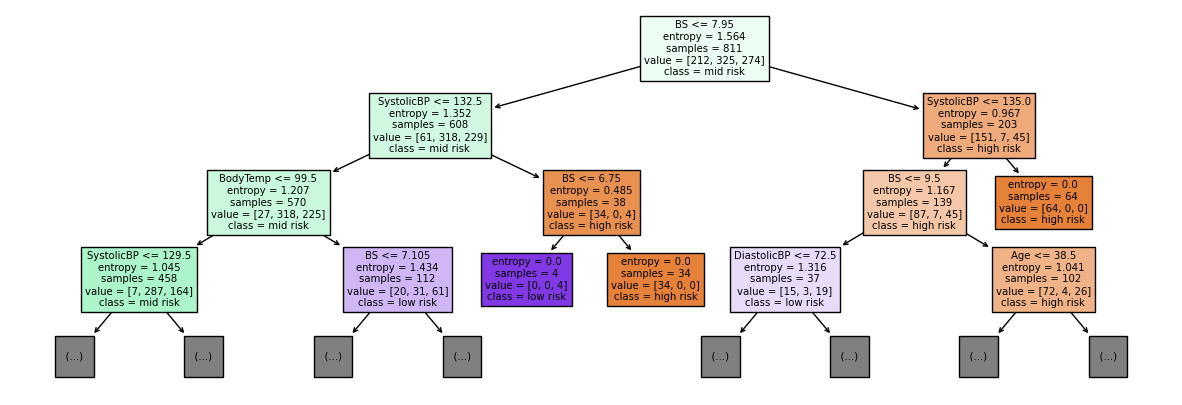

In [25]:
plt.figure(figsize=(15, 5))
plot_tree(
    random_search.best_estimator_,
    feature_names=X_train.columns,
    class_names=y_train.unique(),
    filled=True,
    max_depth=3  # Adjust the depth for better readability
)
plt.show()

Based on the first three levels of the decision tree, the root node of your tree splits on Blood Sugar (BS) with a threshold of 7.95. This indicates that BS is the most important variable in predicting the maternal health risk classification, as it is the first and most influential split in the tree. The next key split (on the left branch of the tree) is SystolicBP (Systolic Blood Pressure) with a threshold of 132.5, suggesting it is the second-most important variable. On the left subtree, further splits involve Body Temperature (BodyTemp) and finer levels of SystolicBP, which highlight their importance in determining mid-risk classification. On the right subtree, DiastolicBP (Diastolic Blood Pressure) and Age are also used to refine classifications, particularly for high-risk predictions. Blood Sugar (BS) stands out as the key indicator for maternal health classification since it governs the initial split and directs subsequent branching based on its values.

# References

Ahmed, M., Kashem, M.A., Rahman, M. and Khatun, S. 2020. "Review and Analysis of Risk Factor of Maternal Health in Remote Area Using the Internet of Things (IoT)". Lecture Notes in Electrical Engineering, vol 632

Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.

Pima Indians Diabetes Database, https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names, 22 Nov 2024.

Target Heart Rates Chart, https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates, 29 Nov 2024. 

Kolhatkar, V. (2023). Lecture 4: Preprocessing, Sklearn Pipeline, Sklearn ColumnTrasnsformer. GitHub. https://pages.github.ubc.ca/mds-2024-25/DSCI_571_sup-learn-1_students/lectures/notes/04_preprocessing-pipelines-column-transformer.html#let-s-first-run-our-baseline-model-dummyregressor

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.